In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import json

In [3]:
# Set paths
data_dir = '/content/drive/MyDrive/Coffee/Dev/C1/leaf disease/dataset'  # Update this path
num_classes = 4
batch_size = 32
img_size = (128, 128)


# Preprocess data

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Still categorical for MobileNetV2
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1332 images belonging to 4 classes.
Found 332 images belonging to 4 classes.


# Train

In [5]:
# Save class indices for later use
class_indices = train_generator.class_indices
with open('/content/drive/MyDrive/Coffee/Dev/C1/leaf disease/class_indices_coffee_l_disease.json', 'w') as f: # Update this path
    json.dump(class_indices, f)

# Load MobileNetV2 base model without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3),
    alpha=0.35
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Reduced neurons for efficiency
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32, 8) │        384 │ block_1_depthwis

 Total params: 574,692 (2.19 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 410,208 (1.56 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 492s 12s/step - accuracy: 0.3408 - loss: 1.4593 - val_accuracy: 0.5844 - val_loss: 1.0586
Epoch 2/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6250 - loss: 1.0811

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.6250 - loss: 1.0811 - val_accuracy: 0.6031 - val_loss: 1.0508
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 587ms/step - accuracy: 0.5105 - loss: 1.1049 - val_accuracy: 0.7406 - val_loss: 0.8255
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6250 - loss: 0.8707 - val_accuracy: 0.7156 - val_loss: 0.8171
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 584ms/step - accuracy: 0.6748 - loss: 0.8149 - val_accuracy: 0.7937 - val_loss: 0.6793
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7812 - loss: 0.5837 - val_accuracy: 0.7656 - val_loss: 0.6864
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 589ms/step - accuracy: 0.7372 - loss: 0.6982 - val_accuracy: 0.8375 - val_loss: 0.5745
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6250 - loss: 0.9690 - val_accuracy: 0.8438 - val_loss: 0.5652
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 577ms/step - accuracy: 0.7801 - loss: 0.6163 - val_accuracy: 0.8313 - 

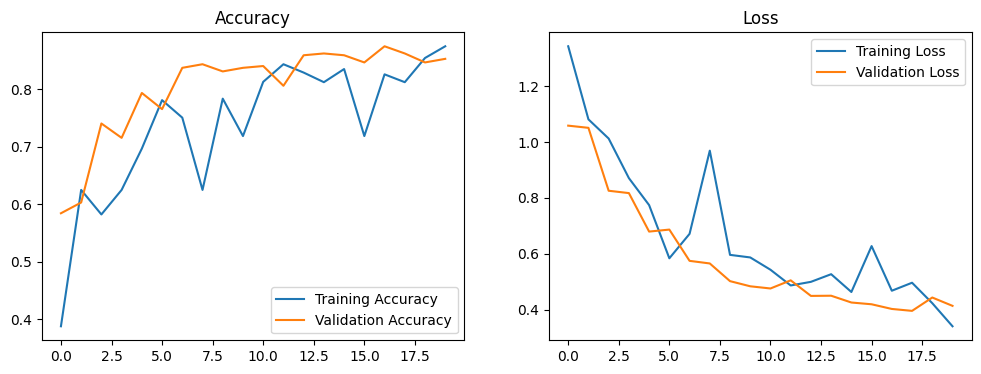

In [6]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_pd_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced patience for faster training
    restore_best_weights=True
)

# Calculate steps per epoch
total_train_samples = train_generator.samples
total_val_samples = validation_generator.samples

steps_per_epoch = total_train_samples // batch_size
validation_steps = total_val_samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,  # Reduced epochs
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# FineTune

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6194 - loss: 0.9283 - val_accuracy: 0.8313 - val_loss: 0.4308
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6250 - loss: 0.8917 - val_accuracy: 0.8344 - val_loss: 0.4540
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 551ms/step - accuracy: 0.7570 - loss: 0.6491 - val_accuracy: 0.8188 - val_loss: 0.4955
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6250 - loss: 1.0375 - val_accuracy: 0.8094 - val_loss: 0.4927
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 0.7261 - loss: 0.6735 - val_accuracy: 0.8281 - val_loss: 0.5113
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9062 - loss: 0.2567 - val_accuracy: 0.7937 - val_loss: 0.5466


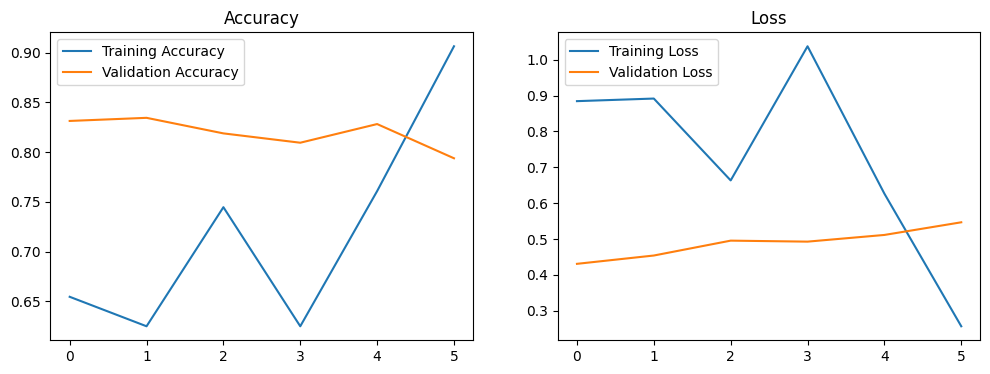

In [7]:
# Fine-tuning: Unfreeze some layers
base_model.trainable = True
# Let's unfreeze the top 50 layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,  # Reduced fine-tuning epochs
    callbacks=[checkpoint, early_stopping]
)

plot_history(history_fine)

# Save the final model
model.save('/content/drive/MyDrive/Coffee/Dev/C1/leaf disease/coffee_l_disease_classifier.keras', save_format='keras') # Update this path


# Evaluation

In [8]:
# Load the best model for evaluation
from tensorflow.keras.models import load_model
best_model = load_model('best_pd_model.keras')

# Evaluate on validation set
val_loss, val_acc = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc*100:.2f}%')


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8804 - loss: 0.3985
Validation Accuracy: 86.45%


# Inference

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the trained Keras model
from tensorflow.keras.models import load_model
import json
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model_path = '/content/drive/MyDrive/Research Project/C1/leaf disease/coffee_l_disease_classifier.keras' # model path # Update this path
loaded_model = load_model(model_path)

# Load class indices
class_indices_path = '/content/drive/MyDrive/Research Project/C1/leaf disease/class_indices_coffee_l_disease.json' # class indices path # Update this path
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)

# Function to preprocess and predict on a new image
def predict_image(model, class_indices, image_path, img_size=(128, 128)):
    # Load and resize the image
    img = image.load_img(image_path, target_size=img_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape (add batch dimension)
    img_array = np.expand_dims(img_array, axis=0)
    # Rescale the image (if your model was trained with rescaling)
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class index and confidence
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Map index to class name
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_class_name = idx_to_class.get(predicted_class_index, 'Unknown')

    return predicted_class_name, confidence


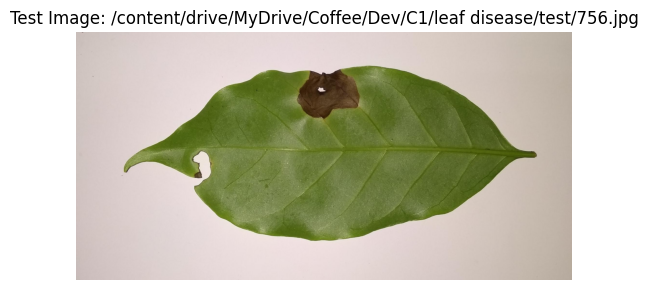

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted: phoma with 67.34% confidence


In [ ]:
# Update this path

test_image_path = '/content/drive/MyDrive/Research Project/C1/leaf disease/test/70.jpg'

import matplotlib.pyplot as plt

# Load and display the image
img = tf.keras.preprocessing.image.load_img(test_image_path)
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title(f'Test Image: {test_image_path}')
plt.show()

predicted_class, confidence = predict_image(loaded_model, class_indices, test_image_path)
print(f'Predicted: {predicted_class} with {confidence*100:.2f}% confidence')